In [150]:
%matplotlib inline

In [151]:
# the -2 loglikelihood is
# -2 ln L \propto m^T C^-1 m + lnDet C
# where C = S + N
# We are working with noiseless maps, N = 0, so C = S
#
# In real space, 
# data: the temperature map, 
# parameters: theoretical CAMB generated C_l, C^theory_l 
#
# m = array of temperature pixels
# S = S_ij
# N = diagonal noise (but here it is noiseless! N=0)
#
# In spherical harmonic space
# data: the Healpix anafast outputarray of a_lm (or similarly, \hat{C}_l )
# parameters: the theoretical C_l
#
# m = a_lm coefficients
# S is diagonal (C_2, C_3, etc.)
# N is non-sparse matrix (but here it is noiseless! N=0)
#

In [152]:
# On the "a_3" issue:  
# Just plot the real-space likelihood for the variance of the l=3 modes for a randomly generated map, 
# and also the seven a_3m amplitudes of that same map.  You see what I mean?  
# We can write down a likelihood for Var(a_3m) 
# and also measure the seven values and compute their empirical variance.  
# The likelihood should peak near the empirical variance.
#
#
#

In [153]:
#
# Plot the spherical likelihood function against parameters theroetical C_l
#
# Import the packages, define x, define y, define your likelihood function, and plot
#
# We begin with l=3. 
#
# Our input data is CAMB generated, noiseless full-sky map
# We calculate an array of a_lm from this by using Healpix map2alm, a subroutine of anafast
# 
# Our parameters are the theoretical values of C_l, also calculated with CAMB Boltzmann codes
#
# The likelihood function for a single a_lm is assumed to follow a Gaussian distribution, N(\mu, \sigma)
# Therefore, because a_lm is i.i.d, the likelihood for all measurements is the product of Gaussians
# 
# In order to plot the log-likelihood function, we need to manipulate use data 
# \hat{C_l}=\fac{1}{2l+1}\sum|a_lm|**2, summing over m
#

In [154]:
import math
import matplotlib.pyplot as plt 
import numpy as np
import healpy as hp
import pyfits as pf
import astropy as ap
import os
from scipy.special import eval_legendre  ##special scipy function


In [155]:
cd ~/desktop/likelihood_comparison

/Users/evanbiederstedt/Desktop/Likelihood_Comparison


In [156]:
# We first construct our data set, theoretical C_l, and a_lm generated from a temperature map
#
# \hat{C_l} is generated from Healpix anafast
#

In [157]:
camb1 = "camb_nside16_lmax32_alms.fits"
camb2 = "camb_nside16_lmax32_map.fits"
camb3 = "camb_nside16_lmax32_scalcls.fits"
planck1 = "100GHz_nside16_lmax32_cls.fits"
planck2 = "100GHz_nside16_lmax32_cmb_alm.fits"
planck3 = "100GHz_nside16_lmax32_sky_alm.fits"
planck4 = "100GHz_nside16_lmax32_skymap.fits"

nside = 16

In [158]:
npix = 12*(nside**2) #total number of pixels, npix
LMAX = ((2*nside)) #maximum l of the power spectrum C_l
heal_npix = hp.nside2npix(nside) # Healpix calculated npix

print "The total number of pixels is " + str(npix)
print "The maximum ell of the power spectrum C_l set to lmax = 2*nside " +str(LMAX)
print "Healpix tells me total number of pixels npix is equal to " + str(heal_npix)

The total number of pixels is 3072
The maximum ell of the power spectrum C_l set to lmax = 2*nside 32
Healpix tells me total number of pixels npix is equal to 3072


In [159]:
mapread_camb2 = hp.read_map(camb2) # Healpix routine, input the sky map

NSIDE = 16
ORDERING = RING in fits file


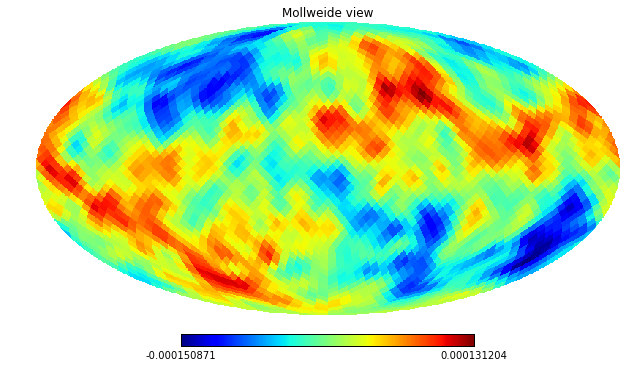

In [160]:
hp.mollview(mapread_camb2) # visualization of full-sky CMB map, nside=16, lmax=32

In [161]:
# open a FITS file 
# type()=pyfits.hdu.hdulist.HDUList
ff = pf.open(camb1)
# recall camb1 = CAMB generated alm values

In [162]:
alms_arr1 = ff[1].data # type()= pyfits.fitsrec.FITS_rec

# Format found in F90 subroutines, alm_map_template.f90
#
# complex(KALMC), intent(OUT), dimension(1:1,0:nlmax,0:nmmax) :: alm
# complex(KALMC), intent(OUT), dimension(1:3,0:nlmax,0:nmmax) :: alm_TGC
#
# From F90 subroutine documenation: 
# http://healpix.sourceforge.net/pdf/subroutines.pdf
# p.95-96
#
# OUTPUT alm TGC(1:p, 0:nlmax, 0:nmmax)
# p is 1 or 3 dependent on whether polarisation is included or not. 
# In the former case, the first index is (1,2,3) corresponding to (T,E,B).
#

In [163]:
print alms_arr1[:10]
#
# final value (1089, 5.9217967e-08, 3.8076456e-07)]
# 

[(1, 0.0, 0.0) (3, 0.0, 0.0) (4, -0.0, -0.0) (7, -3.9906776e-05, 0.0)
 (8, -8.628399e-06, -8.1914368e-05) (9, -3.1374161e-06, 1.2407137e-05)
 (13, -3.5482128e-05, 0.0) (14, -2.8170263e-05, 3.8942499e-06)
 (15, 2.697136e-05, -1.492875e-06) (16, -2.6893406e-06, 9.8793671e-06)]


In [164]:
len(hp.map2alm(mapread_camb2))

1176

In [165]:
# healpy.sphtfunc.anafast(map1, map2=None, nspec=None, lmax=None, mmax=None, 
#                         iter=3, alm=False, pol=True, use_weights=False, datapath=None))
anafast_camb2 = hp.anafast(mapread_camb2, lmax=LMAX)

# use default alm = False
# output array of C_l values calculated from full-sky map

In [166]:
len(anafast_camb2)
print "length of anafast_camb2 C_l output array is " + str(len(anafast_camb2))
print "C_0, C_1, ..., C_"+str(len(anafast_camb2)-1) +" has the length "+ str(len(anafast_camb2))

length of anafast_camb2 C_l output array is 33
C_0, C_1, ..., C_32 has the length 33


In [167]:
print anafast_camb2 # recall, the first two values are the monopole and dipole

[  5.60662902e-22   1.04074505e-21   3.09778663e-09   6.49352544e-10
   3.16267210e-10   1.41906453e-10   1.26861868e-10   9.30887337e-11
   6.11556431e-11   2.67423769e-11   4.27144594e-11   2.08222245e-11
   7.90677044e-12   1.58747828e-11   1.74295868e-11   1.00827966e-11
   8.60478139e-12   7.35599751e-12   6.25064299e-12   4.19404244e-12
   4.24873723e-12   2.36003713e-12   1.98533608e-12   1.89714710e-12
   1.87076443e-12   1.55496519e-12   9.21909623e-13   7.07174585e-13
   6.89339796e-13   4.76548579e-13   2.84266439e-13   3.39182441e-13
   2.29954575e-13]


In [168]:
# open a FITS file, theoretical C_l values generated by CAMB
# type()=pyfits.hdu.hdulist.HDUList
ff_camb = pf.open(camb3)
# recall camb3 = "camb_nside16_lmax32_scalcls.fits"

In [169]:
theoryCls_arr1 = ff_camb[1].data
print theoryCls_arr1[:10]
# Recall there are four columns: temp, E pol, B pol, grad-temp cross terms
# first two values are zero, i.e. monopole, dipole
# XXX.field() references columns by 0-index
# field(0) is temperature values
# all Cl scalar temp values put into ndarray
# type()=numpy.ndarray

[(0.0, 0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0)
 (1.2639207e-09, 5.5308927e-14, 0.0, 3.6016001e-12)
 (5.8827504e-10, 4.5345086e-14, 0.0, 2.2704995e-12)
 (3.2867314e-10, 3.0680604e-14, 0.0, 1.4030458e-12)
 (2.065753e-10, 1.8198442e-14, 0.0, 8.6680196e-13)
 (1.4100289e-10, 9.6222612e-15, 0.0, 5.4035639e-13)
 (1.0233801e-10, 4.5884262e-15, 0.0, 3.3960166e-13)
 (7.7812937e-11, 2.0448748e-15, 0.0, 2.1437516e-13)
 (6.1362422e-11, 9.4503657e-16, 0.0, 1.3715881e-13)]


In [170]:
cltemps = theoryCls_arr1.field(0) 
print cltemps
print "The length of the array of theoretical Cl's is " +str(len(cltemps))

[  0.00000000e+00   0.00000000e+00   1.26392075e-09   5.88275040e-10
   3.28673144e-10   2.06575299e-10   1.41002890e-10   1.02338013e-10
   7.78129366e-11   6.13624221e-11   4.98225766e-11   4.14123076e-11
   3.50811741e-11   3.01814025e-11   2.63133803e-11   2.32104266e-11
   2.06850804e-11   1.86004823e-11   1.68565179e-11   1.53792031e-11
   1.41130128e-11   1.30162998e-11   1.20591913e-11   1.12186076e-11
   1.04760627e-11   9.81660760e-12   9.22804801e-12   8.70035207e-12
   8.22520958e-12   7.79568684e-12   7.40596039e-12   7.05096528e-12
   6.72585642e-12]
The length of the array of theoretical Cl's is 33


In [171]:
#
print "Evaluate spherical harmonic likelihood function, -2 ln L"
print "-2\ln L = \sum_{l}(2l+1)\Big[\ln\Big( \frac{C^{\text{th}}_l}{\hat{C}_l}\Big) +"
print "+\Big(\hat{C}_l/C^{\text{th}}_l\Big)-1 \Big] "
print " 'with some 'irrelevant additive constant'(Verde, astro-ph/0302218))"
print "where HEALPix anafast is \hat(C)_l = frac{1}{2l+1}\sum_m |\hat{a}_{lm}|^2"
#

Evaluate spherical harmonic likelihood function, -2 ln L
-2\ln L = \sum_{l}(2l+1)\Big[\ln\Big( rac{C^{	ext{th}}_l}{\hat{C}_l}\Big) +
+\Big(\hat{C}_l/C^{	ext{th}}_l\Big)-1 \Big] 
 'with some 'irrelevant additive constant'(Verde, astro-ph/0302218))
where HEALPix anafast is \hat(C)_l = frac{1}{2l+1}\sum_m |\hat{a}_{lm}|^2


In [172]:
#define array of ell values
ell_arr = np.arange(33) # lmax = 2*nside = 32 
print ell_arr
# type(ell) = np.ndarray

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]


In [173]:
ell = ell_arr             # the array of ell values, len() = lmax = 2*nside
theoryCl = cltemps        # the array of theoretical C_l calculated above
anafastCl = anafast_camb2 # the array of calculated C_l using Healpix anafast, the DATA

In [174]:
# In spherical harmonic space, 
# Data: Healpix anafast created C_l values from temperature sky maps
# Parameters: theoretical C_l values generated by CAMB
#

def spher_logL(theoryCl):
    spherlikehd = ( (np.log(theoryCl/anafastCl)) + (anafastCl/theoryCl) - 1 )
    loglike = np.sum( ((2 * ell[:, None, None]) + 1 ) * spherlikehd, axis=0)
    return loglike

In [175]:
spher_logL(theoryCl)
# 
# OUTPUT
# array([[             nan,              nan,   6.03812349e+02,
#          5.49243134e+00,   7.95852638e-01,   6.80023415e+01,
#          5.87261225e+00,   4.73532020e+00,   2.92038466e+01,
#          2.90064401e+02,   1.22644676e+01,   2.07302069e+02,
#          7.78994616e+02,   1.83467125e+02,   8.09054598e+01,
#          2.92046934e+02,   3.19168923e+02,   3.51904931e+02,
#          3.95162890e+02,   6.22973117e+02,   5.46162353e+02,
#          9.67945707e+02,   1.05488330e+03,   1.03055309e+03,
#          9.81538489e+02,   1.09011506e+03,   1.52836644e+03,
#          1.73273223e+03,   1.70214284e+03,   2.02105985e+03,
#          2.50307948e+03,   2.26782733e+03,   2.62451438e+03]])
#
#
#
#
#

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in add


array([[             nan,              nan,   6.03812349e+02,
          5.49243134e+00,   7.95852638e-01,   6.80023415e+01,
          5.87261225e+00,   4.73532020e+00,   2.92038466e+01,
          2.90064401e+02,   1.22644676e+01,   2.07302069e+02,
          7.78994616e+02,   1.83467125e+02,   8.09054598e+01,
          2.92046934e+02,   3.19168923e+02,   3.51904931e+02,
          3.95162890e+02,   6.22973117e+02,   5.46162353e+02,
          9.67945707e+02,   1.05488330e+03,   1.03055309e+03,
          9.81538489e+02,   1.09011506e+03,   1.52836644e+03,
          1.73273223e+03,   1.70214284e+03,   2.02105985e+03,
          2.50307948e+03,   2.26782733e+03,   2.62451438e+03]])

In [176]:
print ell
print theoryCl

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
[  0.00000000e+00   0.00000000e+00   1.26392075e-09   5.88275040e-10
   3.28673144e-10   2.06575299e-10   1.41002890e-10   1.02338013e-10
   7.78129366e-11   6.13624221e-11   4.98225766e-11   4.14123076e-11
   3.50811741e-11   3.01814025e-11   2.63133803e-11   2.32104266e-11
   2.06850804e-11   1.86004823e-11   1.68565179e-11   1.53792031e-11
   1.41130128e-11   1.30162998e-11   1.20591913e-11   1.12186076e-11
   1.04760627e-11   9.81660760e-12   9.22804801e-12   8.70035207e-12
   8.22520958e-12   7.79568684e-12   7.40596039e-12   7.05096528e-12
   6.72585642e-12]


In [177]:
# Plot this function, -2 ln L
# y axis should be the likelihood function, func(parameters)
# x axis should be the parameters, theoretical C_l
#
# NOTE: the first two values of -2lnL are 'nan', l=0, l=1 must be first removed
# OTHERWISE user will get ValueError: x and y must have same first dimension
#
newanafastCl = anafastCl[2:]  # len() = 31:   monopole, dipole removed
newell = ell[2:]              # len() = 31:    l=2, l=3, ... l=32
newtheoryCl = theoryCl[2:]    # len() = 31

# We define a new likelihood function with these names

def newspher_logL(newtheoryCl):
    newspherlikehd = ( (np.log(newtheoryCl/newanafastCl)) + (newanafastCl/newtheoryCl) - 1 )
    loglike = np.sum( ((2 * newell[:, None, None]) + 1 ) * newspherlikehd, axis=0)
    return loglike
                              # The x-axis is parameters, theoryCl  
                              # The y-axis is -2 ln L


In [178]:
loglikehd = newspher_logL(newtheoryCl)
print loglikehd
# output is
# [[  6.01594489e+02   5.47225712e+00   7.92929396e-01   6.77525625e+01
#    5.85104159e+00   4.71792692e+00   2.90965781e+01   2.88998967e+02
#    1.22194190e+01   2.06540628e+02   7.76133295e+02   1.82793233e+02
#    8.06082864e+01   2.90974218e+02   3.17996585e+02   3.50612351e+02
#    3.93711420e+02   6.20684878e+02   5.44156247e+02   9.64390350e+02
#    1.05100861e+03   1.02676778e+03   9.77933205e+02   1.08611096e+03
#    1.52275260e+03   1.72636774e+03   1.69589070e+03   2.01363631e+03
#    2.49388543e+03   2.25949738e+03   2.61487429e+03]]
#
#
# Sanity checks
print len(newell)
print len(newtheoryCl)
print len(newanafastCl) # len() should be 31 each

print len(loglikehd)

[[  6.01594489e+02   5.47225712e+00   7.92929396e-01   6.77525625e+01
    5.85104159e+00   4.71792692e+00   2.90965781e+01   2.88998967e+02
    1.22194190e+01   2.06540628e+02   7.76133295e+02   1.82793233e+02
    8.06082864e+01   2.90974218e+02   3.17996585e+02   3.50612351e+02
    3.93711420e+02   6.20684878e+02   5.44156247e+02   9.64390350e+02
    1.05100861e+03   1.02676778e+03   9.77933205e+02   1.08611096e+03
    1.52275260e+03   1.72636774e+03   1.69589070e+03   2.01363631e+03
    2.49388543e+03   2.25949738e+03   2.61487429e+03]]
31
31
31
1


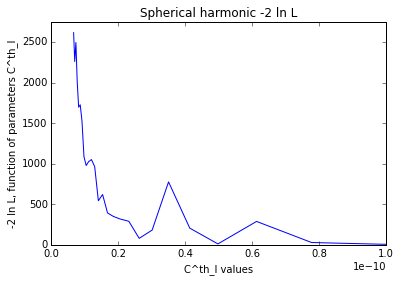

In [179]:
x = newtheoryCl               # The x-axis is parameters, theoryCl, theoretical CAMB C_l parameters
y = loglikehd[0]              # The y-axis is the loglikelihood, -2 ln L
spher_likelihood_plot = plt.plot(x,y)
plt.xlabel('C^th_l values')
plt.ylabel('-2 ln L, function of parameters C^th_l')
plt.title('Spherical harmonic -2 ln L ')
plt.xlim(0.5e-17, 1e-10)
plt.ylim(0,2750)
plt.show()



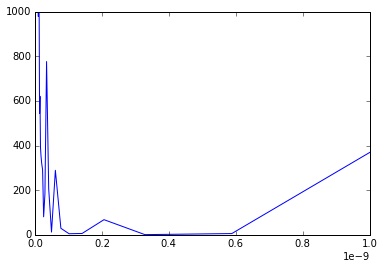

In [180]:
plt.plot(x,y)
#plt.xlabel('Data: Healpix anafast calculated C_l from temp. map, l=2 to l=32')
#plt.ylabel('-2 ln L')
#plt.title('Spherical harmonic -2 ln L ')
plt.xlim(0.5e-17, 1e-09)
plt.ylim(0,1000)
plt.show()

In [181]:
# Also, we can directly use a_lm coefficients
#
# -2 ln L \propto m^T * C^{-1} m + lnDet C
#
# data: a_lm coefficients generated by Healpix routine
# parameters: theoretical C_l values
#
# m =  array of a_lm coefficients NOTE: a11 = a1-1, a22 = a2-2, a21 = a2-1, etc.
# C = diag(C^theory_l)  NOTE: diag(C_l) means det is simply product C_0*C_1*C_2 etc.
# 
# Healpix map2alm (anafast) generates array of a_lm
# such that array = (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33, etc.) betcause m>0  equal to m<0

In [182]:
# Step 1: generate a_lm from CMB map
# Step 2: create -2 ln likelihood function
# Step 3: plot -2 ln L versus parameters, C^th_l


In [183]:
# Our full-sky map is camb2 = "camb_nside16_lmax32_map.fits"
#
arr = hp.map2alm(mapread_camb2)                # This is an array of a_lm values
print "The array of spherical harmonic coefficients a_lm is"
print arr
print "The arr.shape is " + str(arr.shape)
print "The length of a_lm array is " + str(len(arr))
# The length of the alm array is expected to be: 
# (mmax * (2 * lmax + 1 - mmax)) / 2 + lmax + 1)
print "The array output is (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33, etc.)"
# Complex alm are stored in an array that has 
# two dimensions to contain coefficients for positive and negative m values.

The array of spherical harmonic coefficients a_lm is
[  4.27365741e-10 +0.00000000e+00j   2.29584030e-09 +0.00000000e+00j
  -3.99058124e-05 +0.00000000e+00j ...,  -1.15597767e-13 -1.67882747e-13j
   3.93365903e-13 +1.23739664e-13j  -3.22333021e-14 -4.85710276e-14j]
The arr.shape is (1176,)
The length of a_lm array is 1176
The array output is (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33, etc.)


In [184]:
# Start with l=2, array output (a_20, a_21, a_22, a_30, a_31, a_32, a_33)
# Delete first three values
print arr[3:]
# Use only real values
print arr[3:].real
print len(arr[3:].real)

# Output only (a_20, a_21, a_22, a_30, a_31, a_32, a_33) = 7 values
alm_array1 = arr[3:10].real
print alm_array1
print len(alm_array1)
alm_array1.shape

[ -3.54786292e-05 +0.00000000e+00j   2.10319852e-05 +0.00000000e+00j
   9.87750024e-06 +0.00000000e+00j ...,  -1.15597767e-13 -1.67882747e-13j
   3.93365903e-13 +1.23739664e-13j  -3.22333021e-14 -4.85710276e-14j]
[ -3.54786292e-05   2.10319852e-05   9.87750024e-06 ...,  -1.15597767e-13
   3.93365903e-13  -3.22333021e-14]
1173
[ -3.54786292e-05   2.10319852e-05   9.87750024e-06   7.97092193e-06
  -1.18858780e-05  -7.27840112e-06   3.61680988e-07]
7


(7,)

In [185]:
print cltemps # Theoretical C_l values
# C_0, C_1, C_2, C_3, C_4, C_5, ....

# We have to create an array such that (C_2, C_2, C_2, C_3, C_3, C_3, C_3)

theory_Cls_arr = np.matrix([1.26392075e-09, 1.26392075e-09, 1.26392075e-09, 5.88275040e-10,
                           5.88275040e-10, 5.88275040e-10, 5.88275040e-10])

alm_vec = np.matrix(alm_array1)


[  0.00000000e+00   0.00000000e+00   1.26392075e-09   5.88275040e-10
   3.28673144e-10   2.06575299e-10   1.41002890e-10   1.02338013e-10
   7.78129366e-11   6.13624221e-11   4.98225766e-11   4.14123076e-11
   3.50811741e-11   3.01814025e-11   2.63133803e-11   2.32104266e-11
   2.06850804e-11   1.86004823e-11   1.68565179e-11   1.53792031e-11
   1.41130128e-11   1.30162998e-11   1.20591913e-11   1.12186076e-11
   1.04760627e-11   9.81660760e-12   9.22804801e-12   8.70035207e-12
   8.22520958e-12   7.79568684e-12   7.40596039e-12   7.05096528e-12
   6.72585642e-12]


In [186]:
# create second loglikelihood -2 ln L \propto m^T * C^{-1} m + lnDet C



# def lnL_real2(theory_Cls_arr):
#    return alm_array1*theory_Cls_arr*alm_array1.T + np.linalg.slogdet(theory_Cls_arr)
    

In [187]:
print "***********"

***********


In [188]:
# Real-space
#
# Begin calculating S_ij piece by piece, in order to do the summation correctly 
#
# S_ij = sum(2ell+1) C^theory_l P_l(dotproductmatrix)
#
# We first use Healpy routines to create the dotproductmatrix

In [189]:
# Extract pixels from sky map fits file
tempmap_arr = hp.mrdfits(camb2) #type() = list

In [190]:
tempval = tempmap_arr[0][:] #len()=12288, type()=numpy.ndarray

In [191]:
tempval.shape 

(3, 1024)

In [192]:
# The HEALPix standard is fixed at shape = (n, 1024)
# Columns are consistently 1024
# Rows vary
#
# Concatenate array so it is one-dimensional
#
#
# Could use numpy.reshape
# Quicker, probably
# np.reshape(tempval, (1, -1))
#

if npix < 1024: 
    tempdata = tempval
else:
    tempdata = np.concatenate([tempval[i,:] for i in range(tempval.shape[0])])

In [193]:
temp_pix_arr = tempdata
print temp_pix_arr.shape  #This is the total number of pixels in one array

(3072,)


In [194]:
# Begin calculating S_ij piece by piece, in order to do the summation correctly 
#
# S_ij = sum(2ell+1) C_l P_l(dotproductmatrix)
#

In [195]:
totalpix = np.arange(npix) # An array indexing the total number of pixels

In [196]:
## healpy.pixelfunc.pix2vec(nside, ipix, nest=False)
## 
## will give three arrays
## arrays of all x values, all y values, all z values
## RING scheme default
# len()=3
# type()=tuple
#
#

vecval = hp.pix2vec(nside, totalpix) #Nside = 16, type()=tuple


In [197]:
vecvalx = vecval[0] #shape (3072,)
vecvaly = vecval[1]
vecvalz = vecval[2]


In [198]:
## First arrange arrays vertically
## numpy.vstack = Stack arrays in sequence vertically (row wise), input sequence of arrays

totalvecval = np.vstack((vecvalx, vecvaly, vecvalz)) #type()=numpy.ndarray

In [199]:
trans = totalvecval.T #transpose


In [200]:
dotproductmatrix = trans.dot(totalvecval) #take the dot product
#dotproductmatrix.shape = (npix, npix)



In [201]:
# NOT QUICK!!! User beware. I wouldn't try nside=16 on 4 GB RAM
#
# S_ij = sum(2ell+1) C_l P_l(dotproductmatrix)
#
# NOT QUICK!
#
# Use ell array WITH monopole and dipole values
#
# ell = 
# [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
#  25 26 27 28 29 30 31 32]
#
summatrix = np.sum( eval_legendre(ell[:, None, None], dotproductmatrix), axis=0)
#
# numpy.sum(a, axis=None, dtype=None, out=None, keepdims=False)[source]
# a : array_like
# Elements to sum.
# axis : None or int or tuple of ints, optional
# Axis or axes along which a sum is performed. 
# The default (axis = None) is perform a sum over all the dimensions of the input array. 
# axis may be negative, in which case it counts from the last to the first axis.
#

In [202]:
print summatrix.shape

(3072, 3072)


In [203]:
# matrix_total = 
# (1/(4*math.pi)) * sum((2 * ll + 1) * cltemp ) * eval_legendre(ll, matrix_dotprod)
#
# Begin with adding theoretical scalar C_l values
#
add_clvalues = np.sum(ell[:, None, None] * summatrix, axis=0)

In [204]:
# matrix_total = 
# (1/(4*math.pi)) * np.sum((2*ll + 1) * cltemp ) * eval_legendre(ll, matrix_dotprod)

wholematrix = np.sum( (((2 * ell[:, None, None]) + 1) * add_clvalues), axis=0)


In [205]:
# multiply by 1/4pi
covmatrix = (1/(4 * math.pi)) * wholematrix 
# This is the entire covariance matrix S_ij

In [206]:
# Compute temperature space (real space) likelihood
#
# where T is a temperature map array (3072,), S is our above matrix = covmatrix,
# and N is the number of pixels in a vector
#
# First Year Wilkinson Microwave Anisotropy Probe (WMAP) Observations: 
# Parameter Estimation Methodology L. Verde, et al., 2003, ApJS, 148, 195
#
# http://lambda.gsfc.nasa.gov/product/map/dr1/
# pub_papers/firstyear/methodology/wmap_param_method.pdf
#
# print "−2 ln L \propto T*S^{-1}*T + ln detS + N ln 2\pi"

In [207]:
# Create an array of temperature values from the pixels
# temp_pix_arr is the array of pixels, shape (3072,)
#
tempvalues = np.matrix(temp_pix_arr) # sanity check; type() = np.ndarray

In [208]:
print type(tempvalues)
print tempvalues.shape

<class 'numpy.matrixlib.defmatrix.matrix'>
(1, 3072)


In [209]:
temptranspose = tempvalues.T
print temptranspose.shape #sanity check, should be (0, Npix)

(3072, 1)


In [210]:
## Invert covariance matrix, S_ij
## numpy.linalg.inv(a)
## Compute the (multiplicative) inverse of a matrix.
## Given a square matrix a, return the matrix ainv satisfying 
## dot(a, ainv) = dot(ainv, a) = eye(a.shape[0]).
##

inverse = np.linalg.inv(covmatrix)
inversematrix = np.matrix(inverse) # S^{-1}
inversematrix.shape

(3072, 3072)

In [211]:
# WARNING: DO NOT USE NP.LIGALG.DET(A)! 
# Operation will not succeed, gives inf or zero
#
#
#
# numpy.linalg.slogdet
# numpy.linalg.slogdet(a)[source]
# Compute the sign and (natural) logarithm of the determinant of an array.
# INPUT array
# OUTPUT (sign, ln det a)
# sign = A number representing the sign of the determinant. 
# For a real matrix, this is 1, 0, or -1. 
# For a complex matrix, this is a complex number with absolute value 1 (i.e., it is on the unit circle), or else 0.
# ln det a = The natural log of the absolute value of the determinant.
#
lnDetS = np.linalg.slogdet(inversematrix) #type()=tuple
print lnDetS 
type(lnDetS[1])

(1.0, 22147.818340765891)


numpy.float64

In [212]:
# The formalism for the real-space likelihood function
# realtemplikehd = ( tempvalues * inversematrix * temptranspose ) 
# realtemplikehdpt2 = ( tempvalues * inversematrix * temptranspose ) + lnDetS[1]
# realtemplikehdpt3 = ( tempvalues * inversematrix * temptranspose ) + ( lnDetS[1] ) + ((npix)*2*math.pi)

In [213]:
print inversematrix

[[ -1.62321810e+08   1.32186603e+08  -4.68488629e+07 ...,   6.62014398e+07
    3.39047167e+08  -2.66131754e+08]
 [  6.25875655e+07  -4.49320970e+07   5.11665517e+07 ...,   7.42530131e+07
   -8.99859941e+07   8.76564637e+07]
 [ -1.54255024e+08   5.77057315e+07  -4.62116642e+07 ...,  -5.85302971e+07
    1.06542910e+08  -1.00608616e+08]
 ..., 
 [  7.17173018e+05  -4.56068090e+06   4.71605620e+05 ...,  -4.12308958e+07
    3.14607127e+07  -1.89235425e+07]
 [  1.95310808e+07  -6.37166966e+06  -2.08962649e+06 ...,   2.44190885e+07
   -4.36547537e+07   2.72497677e+07]
 [  7.21411736e+06  -7.09940333e+06  -4.67011685e+05 ...,  -2.81988650e+07
   -8.84715321e+06   8.47827286e+06]]


In [214]:
print tempvalues
print tempvalues.shape


[[ -4.00660210e-05  -3.31482152e-05  -3.18903330e-05 ...,   7.95958931e-06
    2.41235625e-06   5.07977290e-07]]
(1, 3072)


In [215]:
print lnDetS

(1.0, 22147.818340765891)


In [216]:
realtemplikehd = ( tempvalues * inversematrix * temptranspose )
print realtemplikehd


[[ -4.38247007e-06]]


In [217]:
# The real-space likelihood
# Data = temperature values
# Parameters = S_ij, based on CAMB-generated C_l theory values
# Recall: The covariance matrix S is a function of model parameters, i.e. theoretical C_l
def real_logL(tempvalues, inversematrix):
    # data = tempvalues, temptranspose
    # parameters = inversematrix, lnDetS = np.slogdet(inversematrix)
    real_loglike = (tempvalues * inversematrix * (tempvalues.T)) + lnDetS[1]
    return real_loglike


In [218]:
real_logL(tempvalues, inversematrix)

matrix([[ 22147.81833638]])

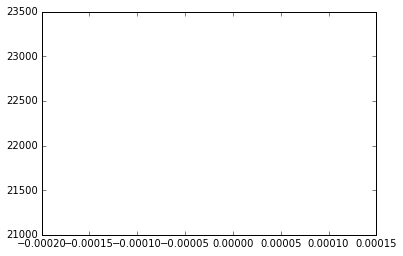

In [219]:
x = tempvalues
y = real_logL(tempvalues, inversematrix)
real_likelihood_plot = plt.plot(x,y)
#plt.xlabel('Data: Healpix anafast calculated C_l from temp. map, l=2 to l=32')
#plt.ylabel('-2 ln L')
#plt.title('Spherical harmonic -2 ln L ')
#plt.xlim(0.5e-13, 1e-10)
#plt.ylim(0,1000)
plt.show()

In [220]:
print inversematrix.shape
print tempvalues.shape
print tempvalues.T.shape
print type(tempvalues)

(3072, 3072)
(1, 3072)
(3072, 1)
<class 'numpy.matrixlib.defmatrix.matrix'>
